In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from dolfin import *
from mshr import *

In [3]:
freq = 50e3
c0 = 1481
omega = 2*np.pi*freq
k0 = omega / c0
wave_len = c0 / freq

tx_radius = 15e-2
tx_aperture_radius = 15e-2
alpha_aperture = np.arcsin(tx_aperture_radius / (2*tx_radius))
dims = (40e-2, 30e-2)

n_wave = 10  # number of mesh elements per wavelength

domain = Rectangle(Point(0, -dims[1]/2), Point(dims[0], dims[1]/2))
domain += Circle(Point(tx_radius*np.cos(alpha_aperture), 0), tx_radius)
mesh = generate_mesh(domain, int(n_wave*min(dims)/wave_len))
V=FunctionSpace(mesh, "Lagrange", 2)

# Time variables
dt = 1e-6
T = 2e-4
t_mesh = np.arange(0, T, dt)

Calling FFC just-in-time (JIT) compiler, this may take some time.


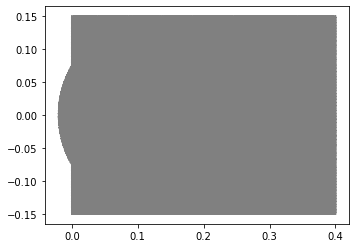

In [4]:
plot(mesh)

In [ ]:
# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dt*c0*c0*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

walls = f'near(x[0], {-dims[0]/2}) || near(x[0], {dims[0]/2}) || near(x[1], {dims[1]})'

def tx_boundary(x, on_boundary):
    return on_boundary and x[0] < 0.

bc_walls = DirichletBC(V, Constant(0.), walls)
bc_tx = DirichletBC(V, Constant(0), tx_boundary)

A, b = assemble_system(a, L, [bc_tx, bc_walls])

u=Function(V)
for ii, t in tqdm(enumerate(t_mesh)):
    bc_tx = DirichletBC(V, Constant(sin(omega*t)), tx_boundary)
    A, b = assemble_system(a, L, [bc_tx, bc_walls])
    #delta = PointSource(V, Point(0, 0), sin(omega*t))
    #delta.apply(b)
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    
    if ii%5 == 0:
        plot(u) #, vmin=-.33, vmax=.33)
        plt.savefig(f'tranducer_prop_test_{ii}')

In [ ]:
![alt text](imagename.png "Title")